# JSON --> CSV

In [11]:
import json
import csv

conversation_name = "consolidated_telemetry"
inputFileName = conversation_name + ".json"
outcsvFileName = conversation_name + "telemetry_output.csv"
# Load the JSON file into a Python Dictionary
with open(inputFileName, 'r') as file:
    data = json.load(file)

# 'data' is now a Python dictionary
#w_file.write(data)

# Access dictionary data
# there are four parts of data in each conversation - 

# Part 1 - Meta data Info
# the consolidated data file includes "consolidation_timestamp", "total_conversations", "total_conversations" and "file_count"

print("*** Part 1 - MetaData Info*** ")
print("consolidation_timestamp: ",  data["metadata"]["consolidation_timestamp"])
print("total_conversations: " ,  data["metadata"]["total_conversations"])
print("total_conversations: ", data["metadata"]["source_directory"])
print("file_count: ", data["metadata"]["file_count"])

# Part 2 - Conversations Info
# Save the conversations Info into a csv file
# Each conversation includes 4 parts - conversation_info, prompts, responses and telemetry


# "telemetry"
# Each telemetry includes 5 attributes -- type, agent_id, timestamp, metadata, details
# metadata - the values in "details" is the first attributes
# 'thought' => context {'prompt' and 'conversation_id'} ** process user's prompt
# 'action_type' =>  {'action_type', 'action_input' (prompt), 'action_output' (none)} 
# 'tool_name' => {'tool_name', 'tool_input' (prompt), 'tool_output' (response)}
# details - 'thought', 'action_type', 'tool_name' 
# create consolidated csv file - source_file, conversation_id, agent_id, conversation_timestamp, type, timestamp, thought, action_type, tool_name, prompt, response
with open(outcsvFileName, 'w') as csv_file:
    fieldNames = ["source_file","conversation_id", "agent_id","conversation_timestamp", "type", "timestamp", "thought", "action_type", "tool_name", "prompt", "response"]
    writer = csv.DictWriter(csv_file, fieldnames=fieldNames)
    writer.writeheader()

    conversations = data["conversations"]
    for conversation in conversations:
        source_file = conversation["source_file"]
        conversation_id = conversation["conversation_id"]
        agent_id = conversation["agent_id"]
        conversation_timestamp = conversation["timestamp"]
        prompts = conversation["prompts"]
        responses = conversation["responses"]
        
        telemetrys = conversation["telemetry"]
        for telemetry in telemetrys:
            if telemetry["type"] == "thinking":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": telemetry["details"]["thought"], "action_type": "none", "tool_name": "none", "prompt": telemetry["metadata"]["context"]["prompt"], "response": "none"})
            elif telemetry["type"] == "action":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": "none", "action_type": telemetry["details"]["action_type"], "tool_name": "none", "prompt": telemetry["metadata"]["action_input"], "response": telemetry["metadata"]["action_output"]})
            elif telemetry["type"] == "tool_use":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": "none", "action_type": "none", "tool_name": telemetry["details"]["tool_name"], "prompt": telemetry["metadata"]["tool_input"], "response": telemetry["metadata"]["tool_output"]})
            else:
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": telemetry["details"], "action_type": telemetry["details"], "tool_name": telemetry["details"], "prompt": "none", "response": "none"})


print("********** program run correctly!!******")
print("read file from ", inputFileName)
print("consolidated data written into csv file, ", outcsvFileName )

*** Part 1 - MetaData Info*** 
consolidation_timestamp:  2025-06-19T14:06:29.656521
total_conversations:  369
total_conversations:  telemetry
file_count:  369
********** program run correctly!!******
read file from  consolidated_telemetry.json
consolidated data written into csv file,  consolidated_telemetrytelemetry_output.csv


# CSV File Table

In [1]:
# These lines import the NumPy and Datascience modules.
from datascience import *
import numpy as np

# These lines do some fancy plotting magic.
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
consolidated = Table.read_table('consolidated_telemetrytelemetry_output.csv')
consolidated.show(20)

source_file,conversation_id,agent_id,conversation_timestamp,type,timestamp,thought,action_type,tool_name,prompt,response
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:08.465146,"Processing user prompt: Hello, how are you today?",none,none,"Hello, how are you today?",none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:08.466644,none,openai_chat,none,"Hello, how are you today?",nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:09.058300,none,none,openai_chat,"Hello, how are you today?","Hello! I'm just a computer program, so I don't have feel ..."
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:10.064109,Processing user prompt: What's the weather like?,none,none,What's the weather like?,none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:10.065628,none,openai_chat,none,What's the weather like?,nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:11.187935,none,none,openai_chat,What's the weather like?,"I'm sorry, I don't have real-time information on the wea ..."
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:12.193256,Processing user prompt: Can you tell me a joke?,none,none,Can you tell me a joke?,none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:12.194746,none,openai_chat,none,Can you tell me a joke?,nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:13.302820,none,none,openai_chat,Can you tell me a joke?,Sure! Here's a joke for you: Why couldn't the bicycle st ...
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:14.305918,Processing user prompt: What is artificial intelligence?,none,none,What is artificial intelligence?,none


In [3]:
from datetime import datetime

begin = consolidated.apply(datetime.fromisoformat, "timestamp")
end = consolidated.apply(datetime.fromisoformat, "conversation_timestamp")
duration =  begin - end

# Duration in seconds
duration = [x.total_seconds() for x in duration] 

In [4]:
print(max(duration), min(duration))

20.641844 1.5e-05


In [5]:
consolidated = consolidated.with_columns("duration", duration)
consolidated.show(20)

source_file,conversation_id,agent_id,conversation_timestamp,type,timestamp,thought,action_type,tool_name,prompt,response,duration
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:08.465146,"Processing user prompt: Hello, how are you today?",none,none,"Hello, how are you today?",none,3.1e-05
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:08.466644,none,openai_chat,none,"Hello, how are you today?",nan,0.001529
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:09.058300,none,none,openai_chat,"Hello, how are you today?","Hello! I'm just a computer program, so I don't have feel ...",0.593185
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:10.064109,Processing user prompt: What's the weather like?,none,none,What's the weather like?,none,1.59899
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:10.065628,none,openai_chat,none,What's the weather like?,nan,1.60051
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:11.187935,none,none,openai_chat,What's the weather like?,"I'm sorry, I don't have real-time information on the wea ...",2.72282
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:12.193256,Processing user prompt: Can you tell me a joke?,none,none,Can you tell me a joke?,none,3.72814
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:12.194746,none,openai_chat,none,Can you tell me a joke?,nan,3.72963
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:13.302820,none,none,openai_chat,Can you tell me a joke?,Sure! Here's a joke for you: Why couldn't the bicycle st ...,4.8377
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:14.305918,Processing user prompt: What is artificial intelligence?,none,none,What is artificial intelligence?,none,5.8408


In [6]:
# I can delete this section from my files once I understand it!
durationAv = consolidated.group("type", np.average).select("type", "duration average") #idk what this does
print(durationAv)
duration_max = consolidated.group("type", max).column("duration max")
duration_min = consolidated.group("type", min).column("duration min")
durationInfo = durationAv.with_columns("duration min", duration_min, "duration max", duration_max)
durationInfo

type     | duration average
action   | 5.68027
thinking | 5.67979
tool_use | 6.94959


type,duration average,duration min,duration max
action,5.68027,0.000102,19.4512
thinking,5.67979,1.5e-05,19.4506
tool_use,6.94959,0.262408,20.6418


In [7]:
duration_table = Table().with_columns(
    'thinking', consolidated.where('type', "thinking").column("duration"),
    'action', consolidated.where('type', "action").column("duration"),
    'tool_use', consolidated.where('type', "tool_use").column("duration")
)
duration_table.show(20)

thinking,action,tool_use
3.1e-05,0.001529,0.593185
1.59899,1.60051,2.72282
3.72814,3.72963,4.8377
5.8408,5.84097,7.62618
8.62712,8.62743,11.719
12.7248,12.725,14.9645
2.3e-05,0.001555,1.62365
2.62895,2.62969,2.98517
3.98724,3.98745,5.09231
6.09759,6.09774,6.88855


In [8]:
def print_statistics(str, tbl):
    x = tbl.column(str)
    print("**", str, "**", " duration time")
    print("Average:", np.average(x))
    print("Min:", min(x))
    print("Max:", max(x))
    
print_statistics("thinking", update_duration_table)
print_statistics("action", update_duration_table)
print_statistics("tool_use", update_duration_table)

NameError: name 'update_duration_table' is not defined

## Histogram

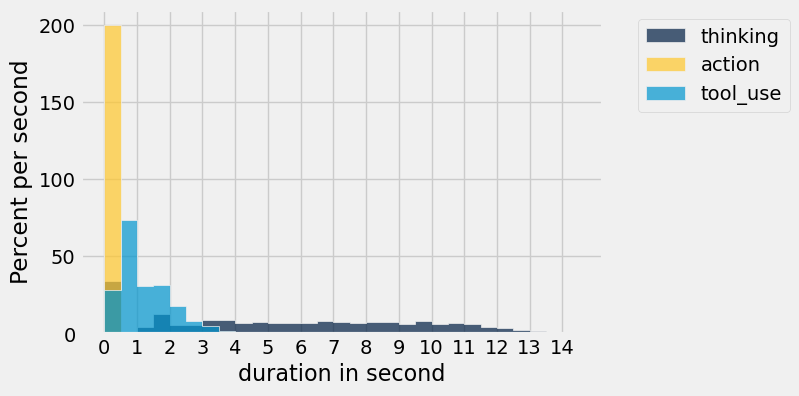

In [ ]:
update_duration_table.hist(bins=np.arange(0, 15, 0.5), unit='duration in second')
_ = plots.xlabel('duration in second')
_ = plots.ylabel('Percent per second')
_ = plots.xticks(np.arange(15))

# Step 2-2: load the csv file using pandas

In [17]:
import pandas as pd  

consolidated_df = pd.read_csv('consolidated_telemetrytelemetry_output.csv')
print(consolidated_df.shape)
print(consolidated_df.describe())
print(consolidated_df.dtypes)

(6642, 11)
                                              source_file  conversation_id  \
count                                                6642             6642   
unique                                                369              369   
top     conversation_conv_1750367014_20250619_140351.json  conv_1750367014   
freq                                                   18               18   

               agent_id      conversation_timestamp      type  \
count              6642                        6642      6642   
unique              369                         369         3   
top     batch-agent-368  2025-06-19T21:03:34.293440  thinking   
freq                 18                          18      2214   

                         timestamp thought action_type tool_name  \
count                         6642    6642        6642      6642   
unique                        6642      26           2         2   
top     2025-06-19T21:03:50.441658    none        none      none   


# Simple Pandas Analysis of 300 Conversations

Let's analyze the telemetry data to understand patterns in the conversations.

In [18]:
# 1. Basic Data Overview
print("=== BASIC DATA OVERVIEW ===")
print(f"Total rows: {len(consolidated_df)}")
print(f"Total columns: {len(consolidated_df.columns)}")
print(f"Data shape: {consolidated_df.shape}")
print()

# Show first few rows
print("First 5 rows:")
print(consolidated_df.head())
print()

# Show data types
print("Data types:")
print(consolidated_df.dtypes)

=== BASIC DATA OVERVIEW ===
Total rows: 6642
Total columns: 11
Data shape: (6642, 11)

First 5 rows:
                                         source_file  conversation_id  \
0  conversation_conv_1750361288_20250619_122824.json  conv_1750361288   
1  conversation_conv_1750361288_20250619_122824.json  conv_1750361288   
2  conversation_conv_1750361288_20250619_122824.json  conv_1750361288   
3  conversation_conv_1750361288_20250619_122824.json  conv_1750361288   
4  conversation_conv_1750361288_20250619_122824.json  conv_1750361288   

       agent_id      conversation_timestamp      type  \
0  custom-agent  2025-06-19T19:28:08.465115  thinking   
1  custom-agent  2025-06-19T19:28:08.465115    action   
2  custom-agent  2025-06-19T19:28:08.465115  tool_use   
3  custom-agent  2025-06-19T19:28:08.465115  thinking   
4  custom-agent  2025-06-19T19:28:08.465115    action   

                    timestamp  \
0  2025-06-19T19:28:08.465146   
1  2025-06-19T19:28:08.466644   
2  2025-06-19T19:2

In [19]:
# 2. Count Analysis
print("=== COUNT ANALYSIS ===")

# Count by type (thinking, action, tool_use)
print("Count by Type:")
type_counts = consolidated_df['type'].value_counts()
print(type_counts)
print()

# Count unique conversations
print(f"Total unique conversations: {consolidated_df['conversation_id'].nunique()}")
print()

# Count by source file
print("Count by Source File:")
source_counts = consolidated_df['source_file'].value_counts()
print(source_counts.head(10))  # Show top 10

=== COUNT ANALYSIS ===
Count by Type:
type
thinking    2214
action      2214
tool_use    2214
Name: count, dtype: int64

Total unique conversations: 369

Count by Source File:
source_file
conversation_conv_1750367014_20250619_140351.json    18
conversation_conv_1750366796_20250619_140010.json    18
conversation_conv_1750366781_20250619_135956.json    18
conversation_conv_1750366769_20250619_135941.json    18
conversation_conv_1750366757_20250619_135929.json    18
conversation_conv_1750366745_20250619_135917.json    18
conversation_conv_1750366731_20250619_135905.json    18
conversation_conv_1750366718_20250619_135851.json    18
conversation_conv_1750366706_20250619_135838.json    18
conversation_conv_1750366692_20250619_135826.json    18
Name: count, dtype: int64


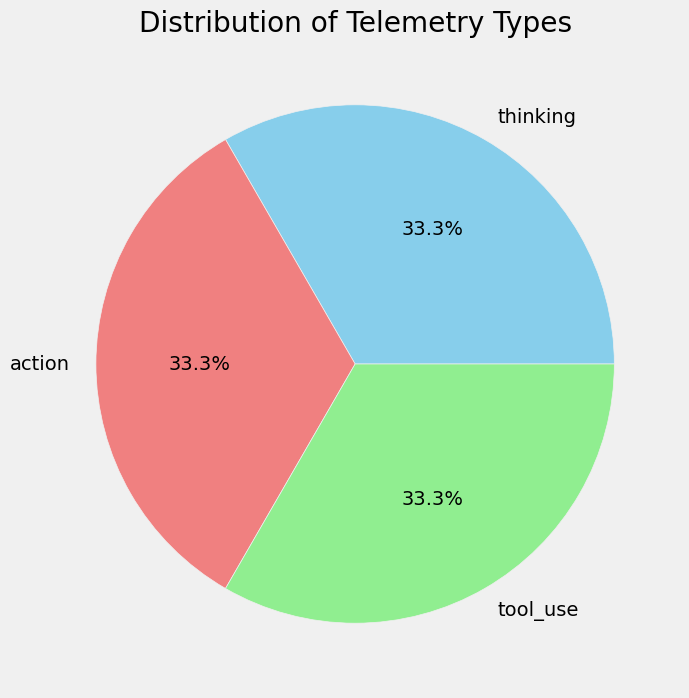

In [20]:
import matplotlib.pyplot as plt

# Pie chart of types
plt.figure(figsize=(8, 8))
type_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Telemetry Types')
plt.ylabel('')  # Remove ylabel for pie chart
plt.show()

In [21]:
# 4. Text Analysis (Prompts and Responses)
print("=== TEXT ANALYSIS ===")

# Filter out 'none' values and get actual text
prompts = consolidated_df[consolidated_df['prompt'] != 'none']['prompt']
responses = consolidated_df[consolidated_df['response'] != 'none']['response']

print(f"Total prompts (non-empty): {len(prompts)}")
print(f"Total responses (non-empty): {len(responses)}")
print()

# Average length of prompts and responses
if len(prompts) > 0:
    avg_prompt_length = prompts.str.len().mean()
    print(f"Average prompt length: {avg_prompt_length:.1f} characters")
    
if len(responses) > 0:
    avg_response_length = responses.str.len().mean()
    print(f"Average response length: {avg_response_length:.1f} characters")

print()


=== TEXT ANALYSIS ===
Total prompts (non-empty): 6642
Total responses (non-empty): 4428

Average prompt length: 23.7 characters
Average response length: 646.4 characters



# Events Per Conversation Analysis


In [22]:
# Events Per Conversation Analysis
print("=== EVENTS PER CONVERSATION ANALYSIS ===")

events_per_conversation = consolidated_df.groupby('conversation_id').size()
print("Sample of events per conversation:")
print(events_per_conversation.head(10))
print()

# Summary statistics
print("=== SUMMARY STATISTICS ===")
print(f"Total conversations: {len(events_per_conversation)}")
print(f"Average events per conversation: {events_per_conversation.mean():.1f}")
print(f"Min events: {events_per_conversation.min()}")
print(f"Max events: {events_per_conversation.max()}")
print(f"Standard deviation: {events_per_conversation.std():.2f}")
print()

# Check if all conversations have the same number of events
unique_counts = events_per_conversation.value_counts().sort_index()
print("=== EVENT COUNT DISTRIBUTION ===")
print("Number of events -> Number of conversations with that count:")
print(unique_counts)
print()

# Are all conversations the same?
if len(unique_counts) == 1:
    print("✅ YES - All conversations have exactly the same number of events!")
    print(f"Every conversation has exactly {events_per_conversation.iloc[0]} events")
else:
    print("❌ NO - Conversations have different numbers of events")
    print(f"Range: {events_per_conversation.min()} to {events_per_conversation.max()} events")
    
    # Show some examples of different sized conversations
    print("\nExamples of conversations with different event counts:")
    for count in unique_counts.index[:5]:  # Show first 5 different counts
        examples = events_per_conversation[events_per_conversation == count].head(3)
        print(f"{count} events: {list(examples.index)}")

print()
print("=== VERIFICATION ===")
print(f"Most common number of events: {events_per_conversation.mode()[0]}")
print(f"Percentage of conversations with the most common count: {(events_per_conversation.value_counts().max() / len(events_per_conversation) * 100):.1f}%")

=== EVENTS PER CONVERSATION ANALYSIS ===
Sample of events per conversation:
conversation_id
conv_1750361288    18
conv_1750362011    18
conv_1750362026    18
conv_1750362041    18
conv_1750362054    18
conv_1750362068    18
conv_1750362081    18
conv_1750362093    18
conv_1750362102    18
conv_1750362115    18
dtype: int64

=== SUMMARY STATISTICS ===
Total conversations: 369
Average events per conversation: 18.0
Min events: 18
Max events: 18
Standard deviation: 0.00

=== EVENT COUNT DISTRIBUTION ===
Number of events -> Number of conversations with that count:
18    369
Name: count, dtype: int64

✅ YES - All conversations have exactly the same number of events!
Every conversation has exactly 18 events

=== VERIFICATION ===
Most common number of events: 18
Percentage of conversations with the most common count: 100.0%


=== UNIFORMITY VISUALIZATION ===


NameError: name 'mean_events' is not defined

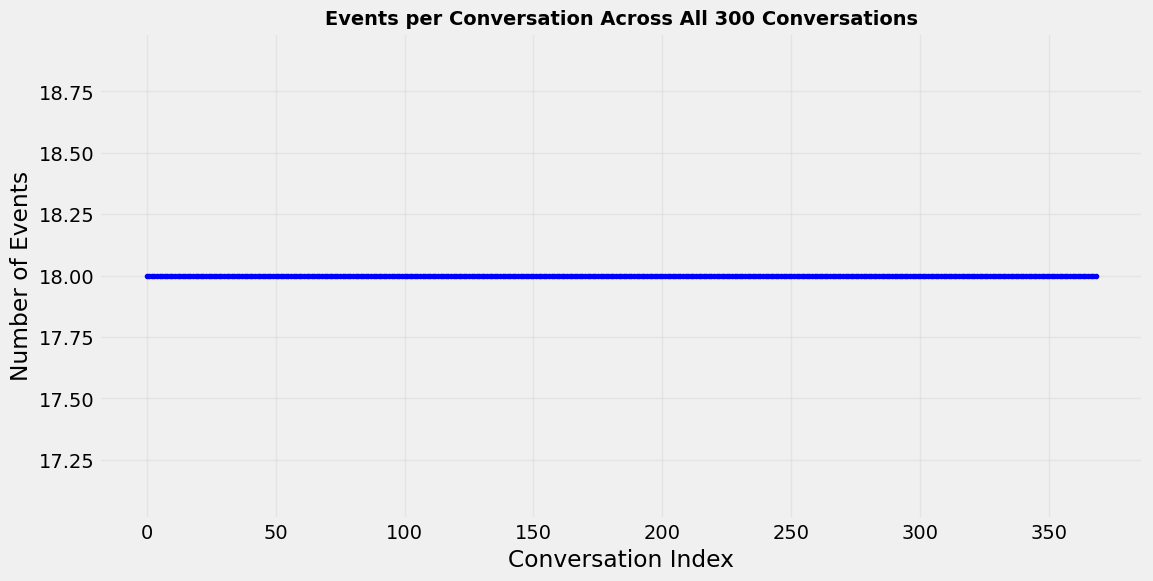

In [23]:
# Visualizing Event Uniformity - Line Plot
import matplotlib.pyplot as plt

print("=== UNIFORMITY VISUALIZATION ===")

# Get events per conversation
events_per_conversation = consolidated_df.groupby('conversation_id').size()

# Create simple line plot
plt.figure(figsize=(12, 6))
conversation_indices = range(len(events_per_conversation))
plt.plot(conversation_indices, events_per_conversation.values, 'o-', markersize=3, linewidth=1, color='blue')
plt.title('Events per Conversation Across All 300 Conversations', fontsize=14, fontweight='bold')
plt.xlabel('Conversation Index')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)

# Add statistics text box
stats_text = f'Mean: {mean_events:.1f}\nStd: {events_per_conversation.std():.2f}\nMin: {events_per_conversation.min()}\nMax: {events_per_conversation.max()}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"), 
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()

# Print uniformity assessment
print("\n=== UNIFORMITY ASSESSMENT ===")
coefficient_of_variation = (events_per_conversation.std() / events_per_conversation.mean()) * 100
print(f"Coefficient of Variation: {coefficient_of_variation:.2f}%")

if coefficient_of_variation < 1:
    print("🟢 EXTREMELY UNIFORM - Very low variation")
elif coefficient_of_variation < 5:
    print("🟡 HIGHLY UNIFORM - Low variation")
elif coefficient_of_variation < 15:
    print("🟠 MODERATELY UNIFORM - Some variation")
else:
    print("🔴 NOT UNIFORM - High variation")

print(f"\nUniformity Score: {100 - min(100, coefficient_of_variation):.1f}/100")

# Histogram Events Per Conversation

=== EVENTS PER CONVERSATION HISTOGRAM ===


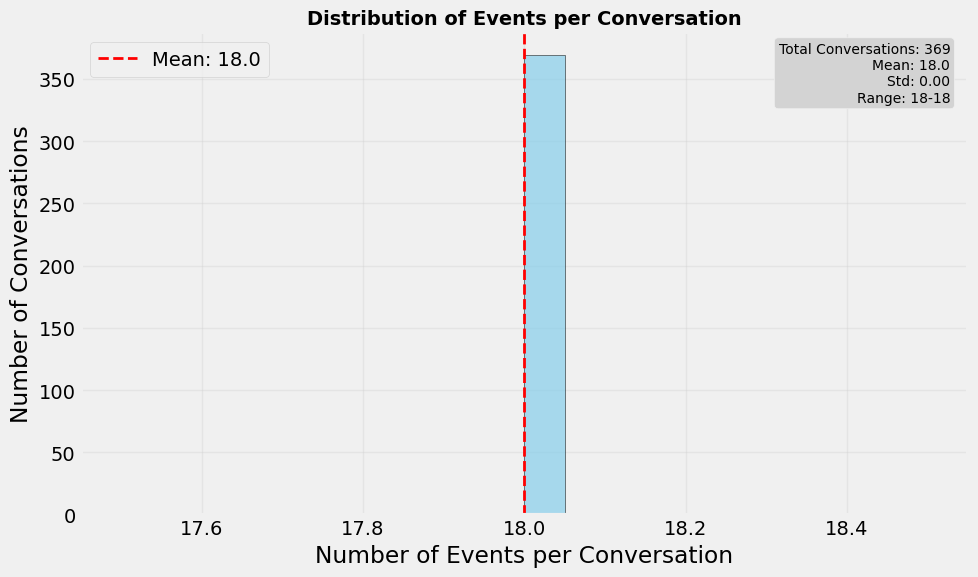

In [25]:
# Histogram of Events Per Conversation
print("=== EVENTS PER CONVERSATION HISTOGRAM ===")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(events_per_conversation.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Events per Conversation', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events per Conversation')
plt.ylabel('Number of Conversations')
plt.grid(True, alpha=0.3)

# Add vertical line for mean
mean_events = events_per_conversation.mean()
plt.axvline(mean_events, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_events:.1f}')
plt.legend()

# Add text box with statistics
stats_text = f'Total Conversations: {len(events_per_conversation)}\nMean: {mean_events:.1f}\nStd: {events_per_conversation.std():.2f}\nRange: {events_per_conversation.min()}-{events_per_conversation.max()}'
plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"), 
         verticalalignment='top', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.show()
